# Zero-coupon vs. Market yields

A zero-coupon yeild is a "synthetic" construct. It is next to impossible to find an actual zero-coupon bond with the exact tenor that trades at those yeilds. It is primarily used as an input to quant/risk models because it is "pure." 

Market yields are shaped mostly by supply and demand. So it is a useful measure for a practical risk-free rate. 

pluto has [zero-coupon](https://plutopy.readthedocs.io/en/latest/YieldCurve.html#plutoPy.model.YieldCurve.IndiaZeroCoupon) rates starting from 2011-01-18 and a market [based bond index](https://plutopy.readthedocs.io/en/latest/Indices.html#plutoPy.model.Indices.IndiaGsecTimeSeries) starting from 2003-12-31. We will plot the yields of the two below to get a sense of the difference between the two.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
indices <- Indices() #for IndiaGsecTimeSeries
ycurves <- YieldCurve() #for IndiaZeroCoupon

In [2]:
startEndDatesIndex <- indices$IndiaGsecTimeSeries() %>%
    summarize(MAX_TS = max(TIME_STAMP), MIN_TS = min(TIME_STAMP)) %>%
    collect()

startEndDatesZero <- ycurves$IndiaZeroCoupon() %>%
    summarize(MAX_TS = max(TIME_STAMP), MIN_TS = min(TIME_STAMP)) %>%
    collect()

startDate <- as.Date(max(startEndDatesIndex$MIN_TS[[1]], startEndDatesZero$MIN_TS[[1]]))
endDate <- as.Date(min(startEndDatesIndex$MAX_TS[[1]], startEndDatesZero$MAX_TS[[1]]))

indexDt <- indices$IndiaGsecTimeSeries() %>%
            filter(TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
            select(TIME_STAMP, NAME, YIELD = YTM) %>%
            collect() %>%
            mutate(MATURITY = as.numeric(gsub(".*\\_","", NAME)), TIME_STAMP=as.Date(TIME_STAMP)) %>% 
            select(TIME_STAMP, MATURITY, YIELD)

ycDt <- ycurves$IndiaZeroCoupon() %>%
            filter(TIME_STAMP >= startDate & TIME_STAMP <= endDate 
                   & MATURITY %in% c(5, 10, 15, 20, 30)) %>%
            collect() %>%
            mutate(TIME_STAMP=as.Date(TIME_STAMP))

print("bond index data:")
print(head(indexDt))
print(tail(indexDt))

print("zero-coupon data:")
print(head(ycDt))
print(tail(ycDt))


[1] "bond index data:"
# A tibble: 6 x 3
  TIME_STAMP MATURITY YIELD
  <date>        <dbl> <dbl>
1 2011-01-18        5  7.94
2 2011-01-19        5  7.96
3 2011-01-20        5  7.93
4 2011-01-21        5  7.93
5 2011-01-22        5  7.93
6 2011-01-23        5  7.93
# A tibble: 6 x 3
  TIME_STAMP MATURITY YIELD
  <date>        <dbl> <dbl>
1 2019-09-07       10  6.64
2 2019-09-08       10  6.64
3 2019-09-09       10  6.63
4 2019-09-10       10  6.63
5 2019-09-11       10  6.66
6 2019-09-12       10  6.68
[1] "zero-coupon data:"
# A tibble: 6 x 3
  TIME_STAMP MATURITY YIELD
  <date>        <int> <dbl>
1 2011-01-18        5  7.75
2 2011-01-18       10  8.23
3 2011-01-18       15  8.42
4 2011-01-18       20  8.51
5 2011-01-18       30  8.6 
6 2011-01-19        5  7.74
# A tibble: 6 x 3
  TIME_STAMP MATURITY YIELD
  <date>        <int> <dbl>
1 2019-09-11       30  7.01
2 2019-09-12        5  6.25
3 2019-09-12       10  6.78
4 2019-09-12       15  6.95
5 2019-09-12       20  7.00
6 2019-09-12 

In [3]:
sprdDf <- indexDt %>% 
    inner_join(ycDt, by=c('TIME_STAMP', 'MATURITY')) %>%
    mutate(SPREAD = 100*(YIELD.x - YIELD.y)) %>%
    as.data.frame()

print(head(sprdDf))
print(tail(sprdDf))

  TIME_STAMP MATURITY YIELD.x YIELD.y SPREAD
1 2011-01-18        5  7.9377  7.7473  19.04
2 2011-01-19        5  7.9570  7.7419  21.51
3 2011-01-20        5  7.9317  7.7366  19.51
4 2011-01-21        5  7.9292  7.8501   7.91
5 2011-01-24        5  7.9290  7.8588   7.02
6 2011-01-25        5  7.9126  7.8651   4.75
      TIME_STAMP MATURITY YIELD.x YIELD.y SPREAD
10350 2019-09-04       10  6.5828  6.6953 -11.25
10351 2019-09-05       10  6.6297  6.7126  -8.29
10352 2019-09-06       10  6.6374  6.7336  -9.62
10353 2019-09-09       10  6.6306  6.7149  -8.43
10354 2019-09-11       10  6.6613  6.7538  -9.25
10355 2019-09-12       10  6.6842  6.7767  -9.25


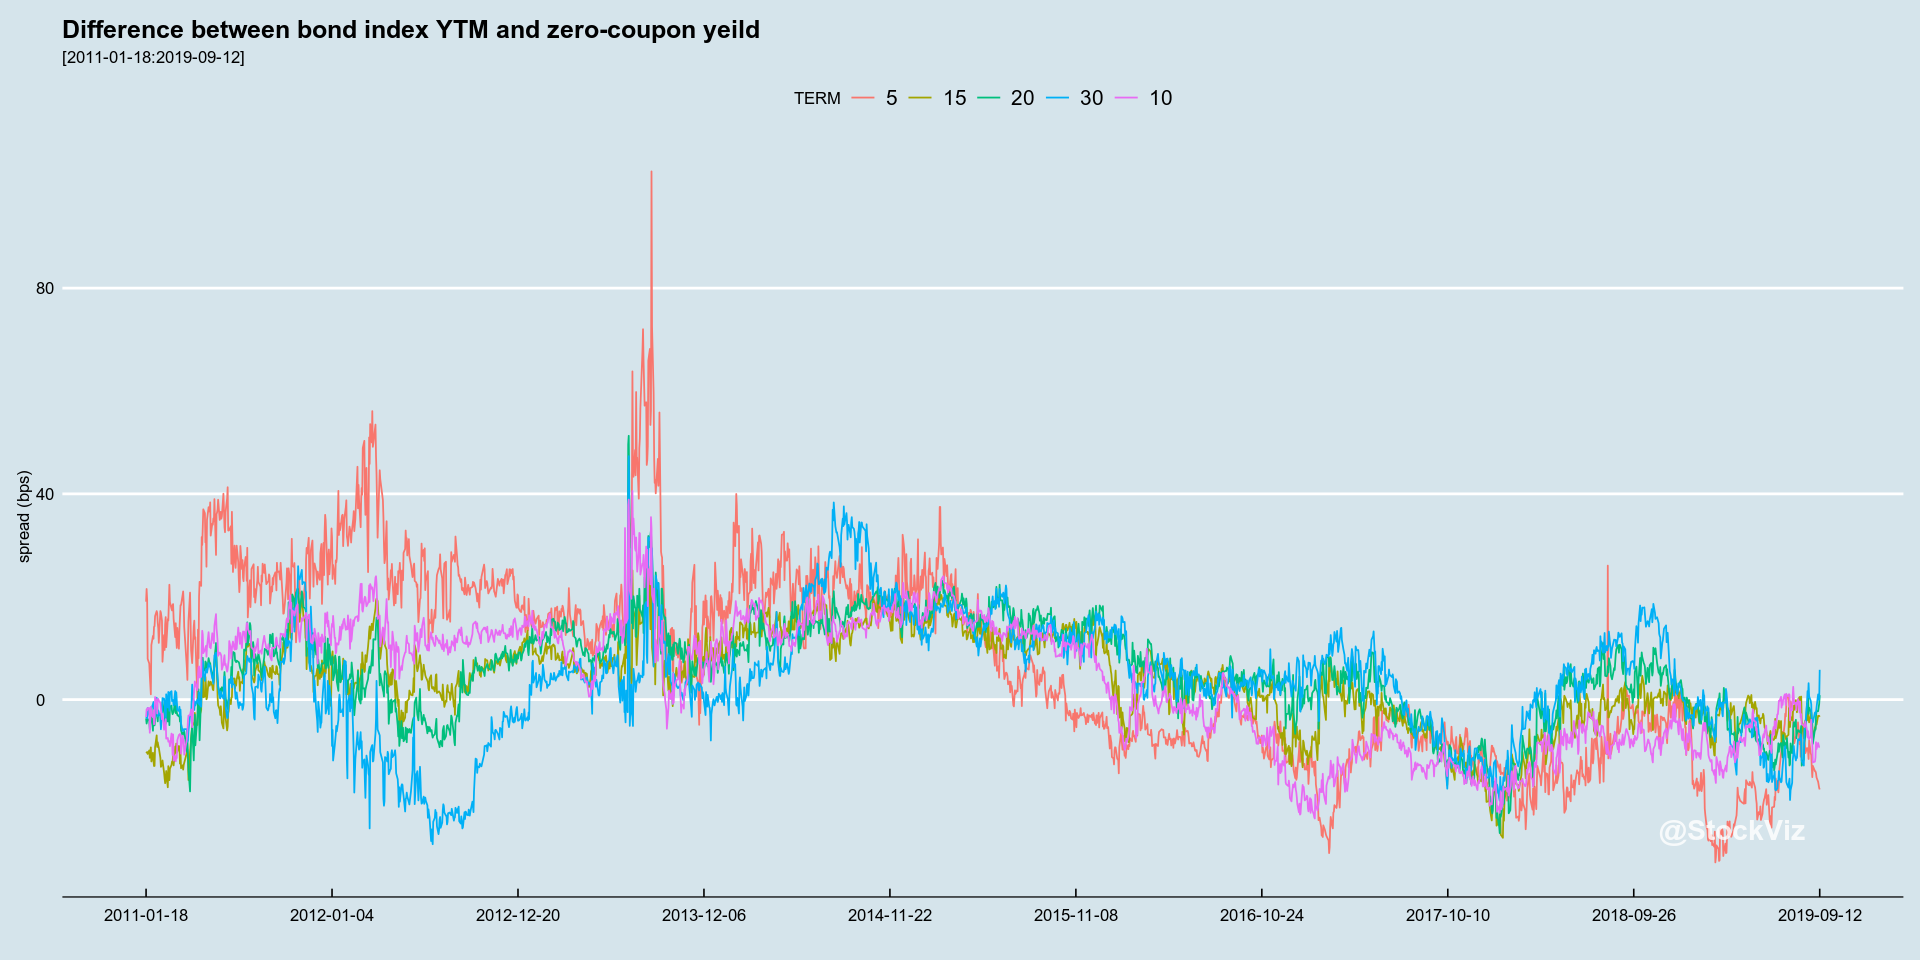

In [4]:
# plot the spread
sprdDf$TERM <- factor(sprdDf$MATURITY, levels = unique(sprdDf$MATURITY))
xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)

ggplot(sprdDf, aes(x = TIME_STAMP, y=SPREAD, color=TERM)) + 
    theme_economist() +
    geom_line() + 
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='spread (bps)', fill='', 
         title="Difference between bond index YTM and zero-coupon yeild", 
         subtitle=sprintf("[%s:%s]", startDate, endDate)) +
    annotate("text", x=max(sprdDf$TIME_STAMP), y=min(sprdDf$SPREAD), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)  

In [5]:
print("across all terms:")
print(summary(sprdDf$SPREAD))

[1] "across all terms:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-31.650  -4.640   4.650   4.479  13.350 102.690 


The difference is mostly within 100bps (1%). It is not **that** big a deal. The zero-coupon curve is cleaner and can be used to analyze models across time. The bond-index yields can be used to price securities for the *hear and the now*. Pick your curve based on your use-case!

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)